In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, 
                           roc_curve, precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_val_score

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_19636\2811828039.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


data loader

In [2]:
def load_census_data():

    try:
        # load data Feature's name come from adult.name 
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num', 
            'marital-status', 'occupation', 'relationship', 'race', 'sex', 
            'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
        ]
        
        # read training data 
        train_data = pd.read_csv(
            'Census Income Data Set/adult.data', 
            names=column_names, 
            na_values=' ?', 
            skipinitialspace=True
        )
        
        # read testing data 
        test_data = pd.read_csv(
            'Census Income Data Set/adult.test', 
            names=column_names, 
            na_values=' ?', 
            skipinitialspace=True,
            skiprows=1  # skip the first line(title)
        )
        return train_data, test_data, column_names
    
    except FileNotFoundError as e:
        print(f"can't find the file: {e}")
        return None, None, None


In [3]:
def preprocess_data(train_data, test_data):
    
    # Create a copy of your data
    train_clean = train_data.copy()
    test_clean = test_data.copy()
    
    
    # Process the target variable (remove periods, unify format)
    train_clean['income'] = train_clean['income'].str.strip()
    test_clean['income'] = test_clean['income'].str.replace('.', '').str.strip()
    
    #Handling missing values ​​for categorical features (filling with mode)
    categorical_cols = ['workclass', 'occupation', 'native-country']
    
    for col in categorical_cols:
        if col in train_clean.columns:
            train_mode = train_clean[col].mode()[0]
            train_clean[col].fillna(train_mode, inplace=True)
            test_clean[col].fillna(train_mode, inplace=True)  # Use the majority
    
    
    #Feature Engineering
    # for age data,creat a group to devide
    def age_group(age):
        if age < 25:
            return 'Young'
        elif age < 45:
            return 'Adult'
        elif age < 65:
            return 'Senior'
        else:
            return 'Elderly'
    
    train_clean['age_group'] = train_clean['age'].apply(age_group)
    test_clean['age_group'] = test_clean['age'].apply(age_group)
    
    # for working time,too
    def hours_group(hours):
        if hours < 30:
            return 'Part-time'
        elif hours < 40:
            return 'Full-time'
        elif hours == 40:
            return 'Standard'
        else:
            return 'Overtime'
    
    train_clean['hours_group'] = train_clean['hours-per-week'].apply(hours_group)
    test_clean['hours_group'] = test_clean['hours-per-week'].apply(hours_group)
    
    # capital loss and gain
    train_clean['has_capital_gain'] = (train_clean['capital-gain'] > 0).astype(int)
    test_clean['has_capital_gain'] = (test_clean['capital-gain'] > 0).astype(int)
    
    train_clean['has_capital_loss'] = (train_clean['capital-loss'] > 0).astype(int)
    test_clean['has_capital_loss'] = (test_clean['capital-loss'] > 0).astype(int)
    
    
    return train_clean, test_clean

# encode and scale
def encode_and_scale(train_data, test_data):
    
    # final features
    categorical_features = [
        'workclass', 'education', 'marital-status', 'occupation', 
        'relationship', 'race', 'sex', 'native-country',
        'age_group', 'hours_group'
    ]
    
    numerical_features = [
        'age', 'fnlwgt', 'education-num', 'capital-gain', 
        'capital-loss', 'hours-per-week', 'has_capital_gain', 'has_capital_loss'
    ]
    
    # One-Hot encoding of categorical features
    train_encoded = pd.get_dummies(train_data, columns=categorical_features, drop_first=True)
    test_encoded = pd.get_dummies(test_data, columns=categorical_features, drop_first=True)
    
    #make sure train data and test data have the same cols
    train_cols = set(train_encoded.columns)
    test_cols = set(test_encoded.columns)
    
    for col in train_cols - test_cols:
        if col != 'income':
            test_encoded[col] = 0
    
    for col in test_cols - train_cols:
        if col != 'income':
            train_encoded[col] = 0
    
    test_encoded = test_encoded[train_encoded.columns]
    
    
    #Separating features and target variables
    X_train = train_encoded.drop('income', axis=1)
    y_train = train_encoded['income']
    X_test = test_encoded.drop('income', axis=1)
    y_test = test_encoded['income']
    
    #Normalizing Numerical Features
    scaler = StandardScaler()
    
    # standardization
    numerical_cols_in_encoded = [col for col in numerical_features if col in X_train.columns]
    
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numerical_cols_in_encoded] = scaler.fit_transform(X_train[numerical_cols_in_encoded])
    X_test_scaled[numerical_cols_in_encoded] = scaler.transform(X_test[numerical_cols_in_encoded])
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

define evaluation

In [4]:
def evaluation(model, X_train, X_test, y_train, y_test, model_name="KNN"):
    results = {}
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    start_time = time.time()
    model.fit(X_train, y_train_encoded)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='binary')
    recall = recall_score(y_test_encoded, y_pred, average='binary')
    f1 = f1_score(y_test_encoded, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
    
    results['model'] = model
    results['y_pred'] = y_pred
    results['y_pred_proba'] = y_pred_proba
    results['y_test_encoded'] = y_test_encoded
    results['training_time'] = training_time
    results['prediction_time'] = prediction_time
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['roc_auc'] = roc_auc
    
    print("=" * 60)
    print(f"{model_name} Model Evaluation Results")
    print("=" * 60)
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))
    
    return results

visualization

In [5]:
def plot_evaluation_curves(results, model_name="KNN"):
    y_test_encoded = results['y_test_encoded']
    y_pred_proba = results['y_pred_proba']
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. ROC curve
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} - ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. PR curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_encoded, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    ax2.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    # 3. confusion matrix
    cm = confusion_matrix(y_test_encoded, results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title(f'{model_name} - Confusion Matrix')
    ax3.set_ylabel('Actual')
    ax3.set_xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()
    
    results['pr_auc'] = pr_auc
    return results

def plot_metrics_comparison(metrics_dict):

    metrics_df = pd.DataFrame(metrics_dict).T
    

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy, Precision, Recall, F1 Score
    performance_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metrics_df[performance_metrics].plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Performance Metrics Comparison')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # AUC Comparison
    auc_metrics = ['roc_auc', 'pr_auc']
    metrics_df[auc_metrics].plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('AUC Metrics Comparison')
    axes[0,1].set_ylabel('AUC Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Time Comparison
    time_metrics = ['training_time', 'prediction_time']
    metrics_df[time_metrics].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Training and Prediction Time Comparison')
    axes[1,0].set_ylabel('Time (seconds)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Composite Score
    metrics_df['composite_score'] = (metrics_df['accuracy'] + metrics_df['f1_score'] + 
                                   metrics_df['roc_auc']) / 3
    metrics_df['composite_score'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Composite Score Comparison')
    axes[1,1].set_ylabel('Average Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

knn model

In [6]:
def knn_model_analysis(X_train, X_test, y_train, y_test, k_values=range(1, 31)):
   
    
    # find a best k
    best_k, best_accuracy, accuracies = find_optimal_k(X_train, X_test, y_train, y_test, k_values)
    
    # useing best k to train the model
    final_knn = KNeighborsClassifier(n_neighbors=best_k)
    
    # evaluation
    results = evaluation(final_knn, X_train, X_test, y_train, y_test, f"KNN (k={best_k})")
    
    # plot the curve
    results = plot_evaluation_curves(results, f"KNN (k={best_k})")
    
    results['best_k'] = best_k
    results['k_accuracies'] = accuracies
    
    return results

def find_optimal_k(X_train, X_test, y_train, y_test, k_range=range(1, 31)):

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    train_accuracies = []
    test_accuracies = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        knn.fit(X_train, y_train_encoded)
        train_pred = knn.predict(X_train)
        train_acc = accuracy_score(y_train_encoded, train_pred)
        train_accuracies.append(train_acc)
        
        test_pred = knn.predict(X_test)
        test_acc = accuracy_score(y_test_encoded, test_pred)
        test_accuracies.append(test_acc)
        
        
    
    plt.figure(figsize=(12, 6))
    plt.plot(k_range, train_accuracies, 'o-', label='Training Accuracy')
    plt.plot(k_range, test_accuracies, 'o-', label='Test Accuracy')
    
    plt.xlabel('K')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    best_k = k_range[np.argmax(test_accuracies)]
    best_accuracy = max(test_accuracies)
    
    print(f"Optimal K value: {best_k}")
    print(f"Best test accuracy: {best_accuracy:.4f}")
    print(f"Corresponding training accuracy: {train_accuracies[np.argmax(test_accuracies)]:.4f}")

    return best_k, best_accuracy, test_accuracies

train ship: (32561, 15)
test ship: (16281, 15)
feature dimension: 108


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_19636\2957134.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean[col].fillna(train_mode, inplace=True)
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_19636\2957134.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

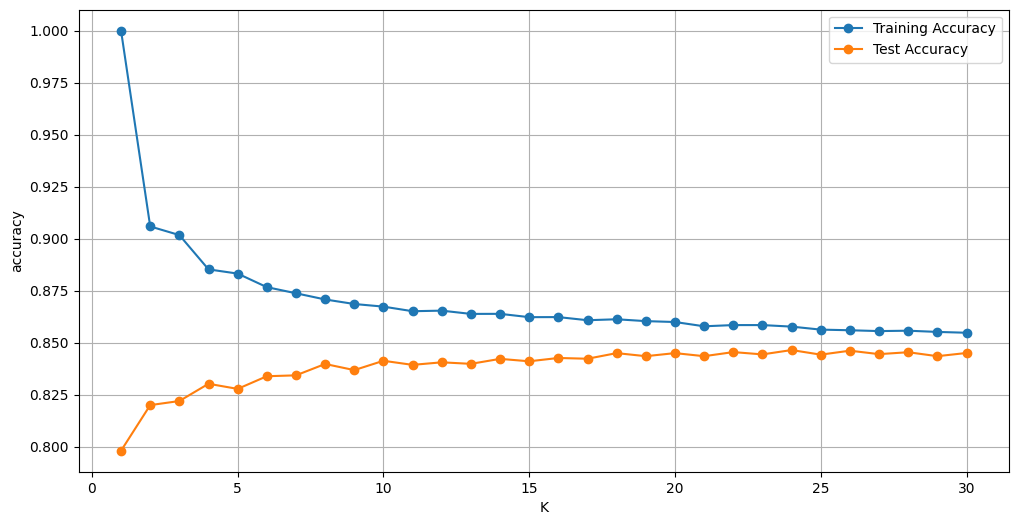

Optimal K value: 24
Best test accuracy: 0.8464
Corresponding training accuracy: 0.8577
KNN (k=24) Model Evaluation Results
Training Time: 0.0712 seconds
Prediction Time: 5.4384 seconds
Accuracy: 0.8464
Precision: 0.7010
Recall: 0.6102
F1 Score: 0.6525
ROC AUC: 0.8963

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     12435
        >50K       0.70      0.61      0.65      3846

    accuracy                           0.85     16281
   macro avg       0.79      0.76      0.78     16281
weighted avg       0.84      0.85      0.84     16281



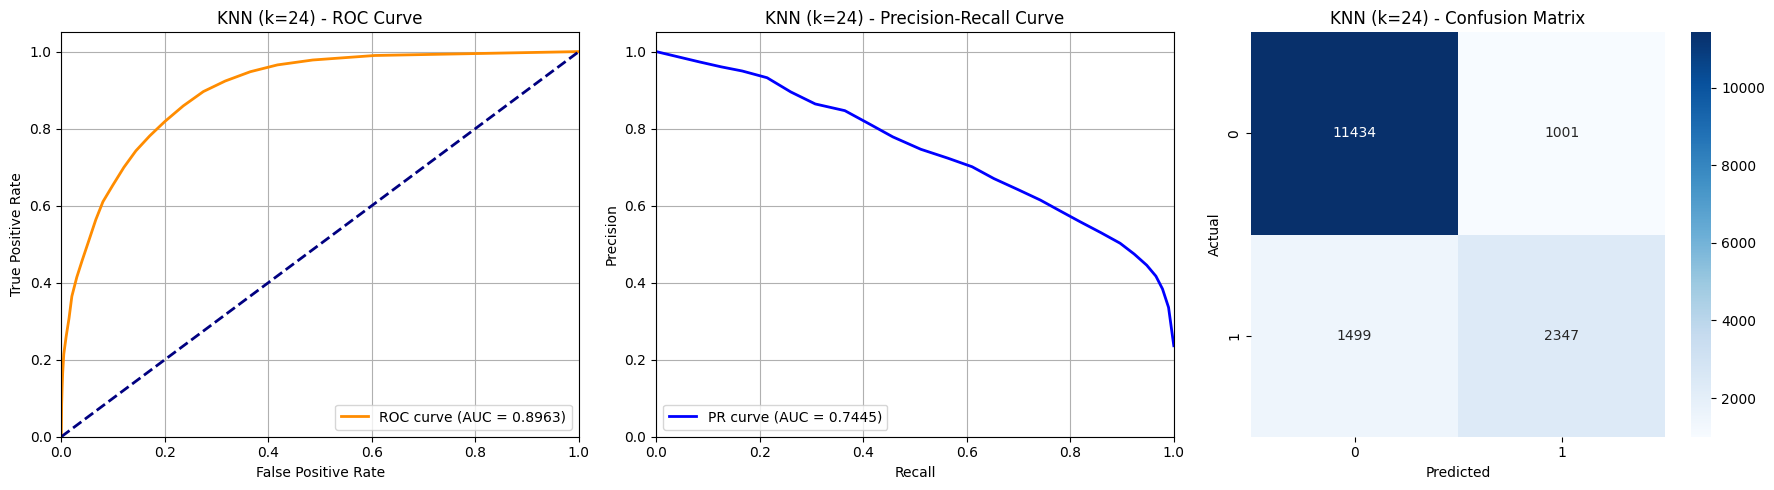

     accuracy  precision  recall  f1_score  roc_auc  pr_auc  training_time  \
KNN    0.8464      0.701  0.6102    0.6525   0.8963  0.7445         0.0712   

     prediction_time  best_k  
KNN           5.4384    24.0  


In [7]:
def main():
    # load_data
    train_data, test_data, column_names = load_census_data()
    
    if train_data is None:
        print("erroe")
        return
    
   
    print(f"train ship: {train_data.shape}")
    print(f"test ship: {test_data.shape}")
    
    # preprocess
    train_clean, test_clean = preprocess_data(train_data, test_data)
    
    # encoding and normalization
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = encode_and_scale(train_clean, test_clean)
    print(f"feature dimension: {X_train_scaled.shape[1]}")
    
    knn_results = knn_model_analysis(X_train_scaled, X_test_scaled, y_train, y_test)
    
    results_summary = {
        'KNN': {
            'accuracy': knn_results['accuracy'],
            'precision': knn_results['precision'],
            'recall': knn_results['recall'],
            'f1_score': knn_results['f1_score'],
            'roc_auc': knn_results['roc_auc'],
            'pr_auc': knn_results['pr_auc'],
            'training_time': knn_results['training_time'],
            'prediction_time': knn_results['prediction_time'],
            'best_k': knn_results['best_k']
        }
    }
    summary_df = pd.DataFrame(results_summary).T
    print(summary_df.round(4))
    
    return knn_results, summary_df

if __name__ == "__main__":
    knn_results, summary_df = main()